# Preprocessing Exploration & Development

Notebook ini untuk **eksperimen dan pengembangan preprocessing pipeline** sebelum di-refactor ke production code (`src/processing.py`).

## Goals:
1. Membuat custom transformer untuk handling invalid zeros
2. Membangun preprocessing pipeline (Imputation + Scaling)
3. Visualisasi before/after preprocessing
4. Verifikasi hasil preprocessing
5. Simpan pipeline untuk digunakan di training

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Dataset

In [24]:
# Load dataset
df = pd.read_csv('../data/diabetes.csv')

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"📊 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")
print(f"\n📋 Feature columns:")
print(X.columns.tolist())

print("\n🔍 First 5 rows of features:")
X.head()

📊 Features shape: (768, 8)
🎯 Target shape: (768,)

📋 Feature columns:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

🔍 First 5 rows of features:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


## 2. Custom Transformer: ZeroToNanTransformer

Custom transformer untuk mengubah nilai 0 menjadi NaN di kolom medis.

In [25]:
class ZeroToNanTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer untuk mengubah nilai 0 menjadi NaN di kolom medis.
    
    Kolom medis yang tidak boleh bernilai 0:
    - Glucose: Plasma glucose concentration
    - BloodPressure: Diastolic blood pressure
    - SkinThickness: Triceps skin fold thickness
    - Insulin: 2-Hour serum insulin
    - BMI: Body mass index
    
    NOTE: Pregnancies=0 adalah VALID (belum pernah hamil)
    """
    
    def __init__(self, medical_columns=None):
        """
        Parameters:
        -----------
        medical_columns : list, default=None
            List of column names where zeros should be converted to NaN.
            If None, uses default medical columns.
        """
        if medical_columns is None:
            self.medical_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        else:
            self.medical_columns = medical_columns
    
    def fit(self, X, y=None):
        """
        Fit method (does nothing, required for sklearn pipeline compatibility).
        """
        return self
    
    def transform(self, X):
        """
        Transform zeros to NaN in medical columns.
        
        Parameters:
        -----------
        X : pd.DataFrame or np.ndarray
            Input features
            
        Returns:
        --------
        X_transformed : pd.DataFrame
            Transformed features with zeros converted to NaN
        """
        # Make a copy to avoid modifying original data
        X_transformed = X.copy()
        
        # Convert to DataFrame if numpy array
        if not isinstance(X_transformed, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=self.medical_columns)
        
        # Replace zeros with NaN in medical columns
        for col in self.medical_columns:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].replace(0, np.nan)
        
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """
        Fit and transform in one step.
        """
        return self.fit(X, y).transform(X)

print("✅ ZeroToNanTransformer class defined successfully")
print("\n📝 Class Info:")
print("   • Medical columns:", ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])
print("   • Action: Replace 0 → NaN in these columns")
print("   • Preserves: Pregnancies (0 is valid)")

✅ ZeroToNanTransformer class defined successfully

📝 Class Info:
   • Medical columns: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
   • Action: Replace 0 → NaN in these columns
   • Preserves: Pregnancies (0 is valid)


## 3. Test Custom Transformer

In [26]:
# Create transformer instance
zero_transformer = ZeroToNanTransformer()

# Transform data
X_transformed = zero_transformer.fit_transform(X)

print("🔍 BEFORE TRANSFORMATION:")
print("="*50)
print("\nNilai 0 di medical columns:")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_count = (X[col] == 0).sum()
    print(f"   {col}: {zero_count} zeros")

print("\n" + "="*50)
print("🔍 AFTER TRANSFORMATION:")
print("="*50)
print("\nNilai NaN di medical columns:")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    nan_count = X_transformed[col].isna().sum()
    zero_count = (X_transformed[col] == 0).sum()
    print(f"   {col}: {nan_count} NaN, {zero_count} zeros")

print("\n✅ Verification:")
print("   • Semua nilai 0 di medical columns sudah converted to NaN")
print("   • Pregnancies tetap memiliki 0 (valid)")
print(f"   • Pregnancies zeros: {(X_transformed['Pregnancies'] == 0).sum()}")

🔍 BEFORE TRANSFORMATION:

Nilai 0 di medical columns:
   Glucose: 5 zeros
   BloodPressure: 35 zeros
   SkinThickness: 227 zeros
   Insulin: 374 zeros
   BMI: 11 zeros

🔍 AFTER TRANSFORMATION:

Nilai NaN di medical columns:
   Glucose: 5 NaN, 0 zeros
   BloodPressure: 35 NaN, 0 zeros
   SkinThickness: 227 NaN, 0 zeros
   Insulin: 374 NaN, 0 zeros
   BMI: 11 NaN, 0 zeros

✅ Verification:
   • Semua nilai 0 di medical columns sudah converted to NaN
   • Pregnancies tetap memiliki 0 (valid)
   • Pregnancies zeros: 111


## 4. Visualisasi Before vs After

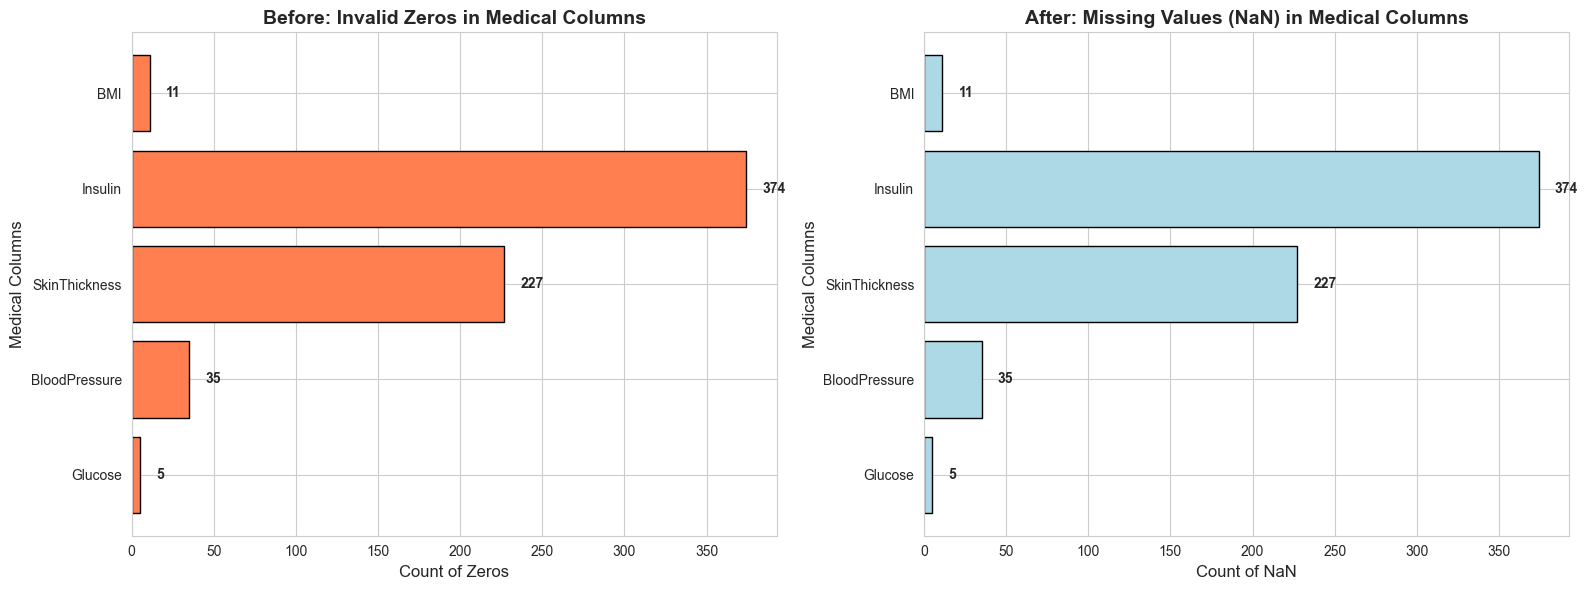


📊 Visualisasi: Invalid Zeros → Missing Values
   • Kiri: Sebelum transformasi (zeros)
   • Kanan: Setelah transformasi (NaN)


In [27]:
# Visualisasi missing values sebelum dan sesudah
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before transformation
medical_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zeros_before = [(X[col] == 0).sum() for col in medical_cols]

axes[0].barh(medical_cols, zeros_before, color='coral', edgecolor='black')
axes[0].set_title('Before: Invalid Zeros in Medical Columns', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count of Zeros', fontsize=12)
axes[0].set_ylabel('Medical Columns', fontsize=12)

# Add count labels
for i, count in enumerate(zeros_before):
    axes[0].text(count + 10, i, str(count), va='center', fontweight='bold')

# After transformation
nans_after = [X_transformed[col].isna().sum() for col in medical_cols]

axes[1].barh(medical_cols, nans_after, color='lightblue', edgecolor='black')
axes[1].set_title('After: Missing Values (NaN) in Medical Columns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count of NaN', fontsize=12)
axes[1].set_ylabel('Medical Columns', fontsize=12)

# Add count labels
for i, count in enumerate(nans_after):
    axes[1].text(count + 10, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Visualisasi: Invalid Zeros → Missing Values")
print("   • Kiri: Sebelum transformasi (zeros)")
print("   • Kanan: Setelah transformasi (NaN)")

## 5. Build Complete Preprocessing Pipeline

Pipeline: Custom Transformer → SimpleImputer → StandardScaler

In [28]:
# Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('zero_to_nan', ZeroToNanTransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print("✅ Preprocessing Pipeline created successfully")
print("\n📋 Pipeline Steps:")
for i, (name, step) in enumerate(preprocessing_pipeline.steps, 1):
    print(f"   {i}. {name}: {step.__class__.__name__}")

print("\n🔧 Step Details:")
print("   1. ZeroToNanTransformer: Convert invalid zeros → NaN")
print("   2. SimpleImputer: Fill NaN with median (robust to outliers)")
print("   3. StandardScaler: Normalize to mean=0, std=1")

✅ Preprocessing Pipeline created successfully

📋 Pipeline Steps:
   1. zero_to_nan: ZeroToNanTransformer
   2. imputer: SimpleImputer
   3. scaler: StandardScaler

🔧 Step Details:
   1. ZeroToNanTransformer: Convert invalid zeros → NaN
   2. SimpleImputer: Fill NaN with median (robust to outliers)
   3. StandardScaler: Normalize to mean=0, std=1


## 6. Fit and Transform Data

In [29]:
# Fit pipeline on training data
preprocessing_pipeline.fit(X)

# Transform data
X_preprocessed = preprocessing_pipeline.transform(X)

print("✅ Pipeline fitted and data transformed")
print(f"\n📊 Preprocessed data shape: {X_preprocessed.shape}")
print(f"📊 Preprocessed data type: {type(X_preprocessed)}")

# Convert to DataFrame for easier inspection
X_preprocessed_df = pd.DataFrame(
    X_preprocessed,
    columns=X.columns
)

print("\n🔍 First 5 rows of preprocessed data:")
X_preprocessed_df.head()

✅ Pipeline fitted and data transformed

📊 Preprocessed data shape: (768, 8)
📊 Preprocessed data type: <class 'numpy.ndarray'>

🔍 First 5 rows of preprocessed data:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496


## 7. Verification: Check Preprocessing Results

In [30]:
print("="*70)
print("🔍 VERIFICATION: Preprocessing Results")
print("="*70)

# Check 1: No missing values
print("\n✅ CHECK 1: Missing Values")
print("-" * 70)
missing_values = X_preprocessed_df.isnull().sum().sum()
print(f"   Total missing values: {missing_values}")
if missing_values == 0:
    print("   ✅ PASSED: No missing values after preprocessing")
else:
    print("   ❌ FAILED: Still have missing values")

# Check 2: Check statistics (should be normalized)
print("\n✅ CHECK 2: Feature Statistics (after StandardScaler)")
print("-" * 70)
stats = X_preprocessed_df.describe()
print("   Mean (should be ~0):")
print(stats.loc['mean'].round(3))
print("\n   Std (should be ~1):")
print(stats.loc['std'].round(3))

if np.allclose(stats.loc['mean'].values, 0, atol=1e-10):
    print("\n   ✅ PASSED: Features are centered (mean ≈ 0)")
else:
    print("\n   ⚠️  WARNING: Means are not close to 0")

if np.allclose(stats.loc['std'].values, 1, atol=0.1):
    print("   ✅ PASSED: Features are scaled (std ≈ 1)")
else:
    print("   ⚠️  WARNING: Standard deviations are not close to 1")

# Check 3: Data range
print("\n✅ CHECK 3: Data Range")
print("-" * 70)
min_values = X_preprocessed_df.min()
max_values = X_preprocessed_df.max()
print("   Min values:")
print(min_values.round(3))
print("\n   Max values:")
print(max_values.round(3))
print("\n   💡 Most values should be in range [-3, 3] after StandardScaler")

# Check 4: No infinities
print("\n✅ CHECK 4: Invalid Values")
print("-" * 70)
has_inf = np.isinf(X_preprocessed_df.values).any()
has_nan = X_preprocessed_df.isnull().sum().sum() > 0

if not has_inf and not has_nan:
    print("   ✅ PASSED: No infinities or NaN values")
else:
    print(f"   ❌ FAILED: Has infinities: {has_inf}, Has NaN: {has_nan}")

print("\n" + "="*70)
print("✅ PREPROCESSING VERIFICATION COMPLETE")
print("="*70)

🔍 VERIFICATION: Preprocessing Results

✅ CHECK 1: Missing Values
----------------------------------------------------------------------
   Total missing values: 0
   ✅ PASSED: No missing values after preprocessing

✅ CHECK 2: Feature Statistics (after StandardScaler)
----------------------------------------------------------------------
   Mean (should be ~0):
Pregnancies                -0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness              -0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Name: mean, dtype: float64

   Std (should be ~1):
Pregnancies                 1.001
Glucose                     1.001
BloodPressure               1.001
SkinThickness               1.001
Insulin                     1.001
BMI                         1.001
DiabetesPedigreeFunction    1.001
Age                         1.001
Name: std, dtype: float64

   ✅ PASSED: Features are cente

## 8. Visualisasi Before vs After Preprocessing

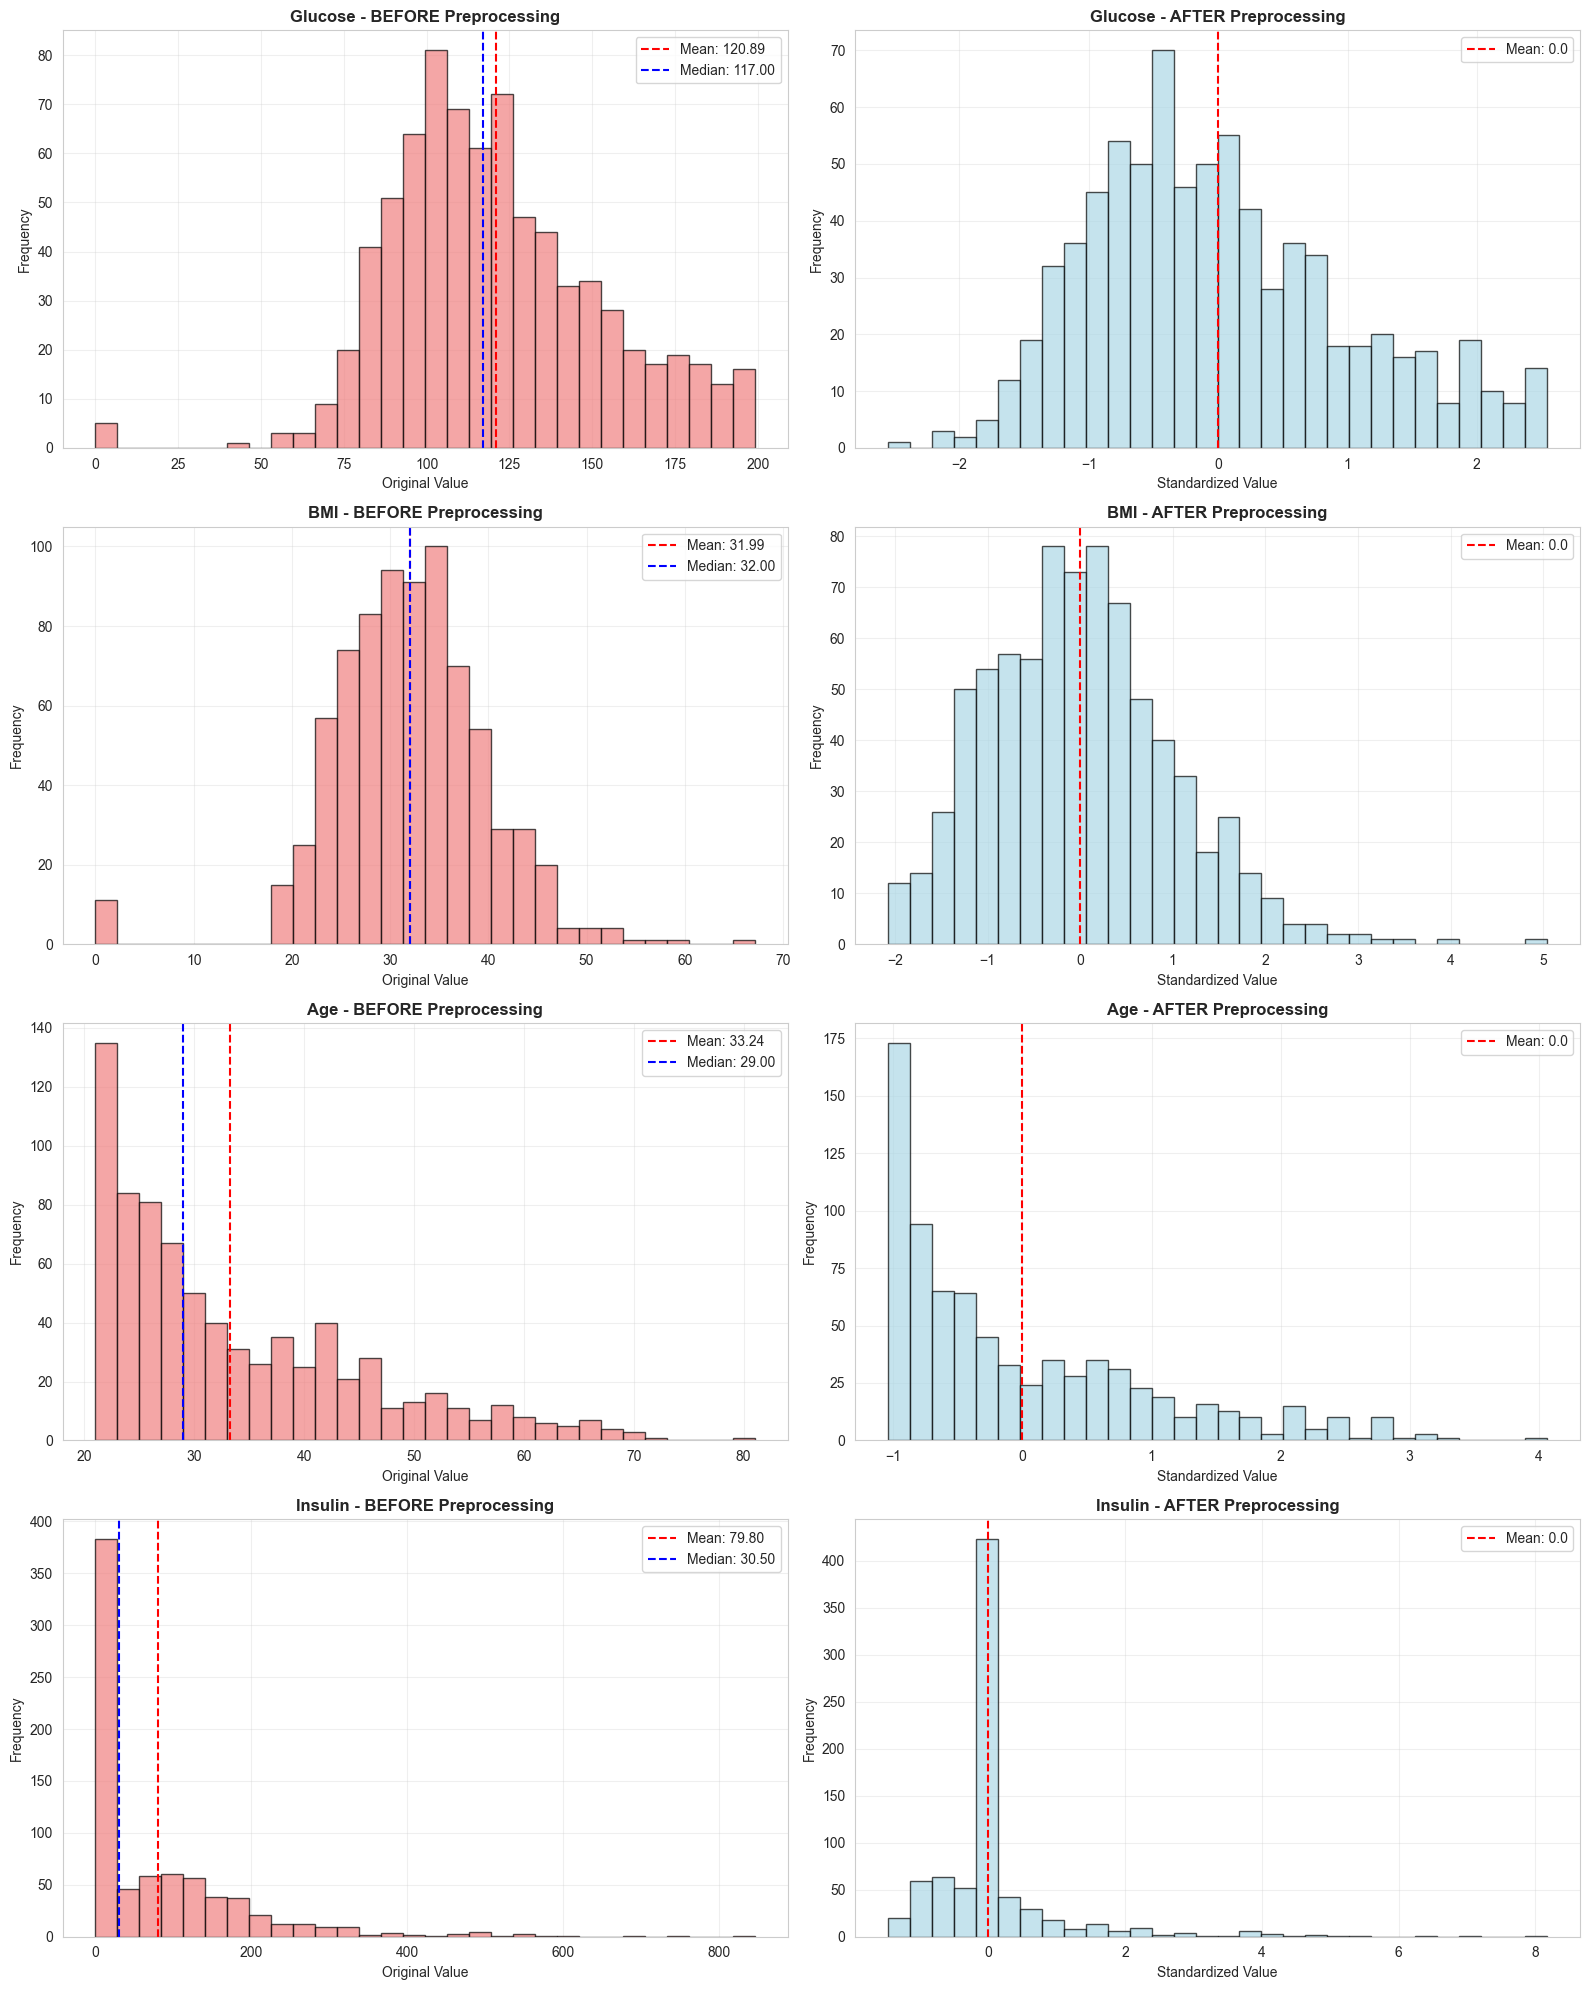


📊 Visualisasi: Before vs After Preprocessing
   • Kiri: Original data (dengan zeros dan outliers)
   • Kanan: Preprocessed data (normalized, no missing values)


In [31]:
# Compare distributions before and after preprocessing
features_to_plot = ['Glucose', 'BMI', 'Age', 'Insulin']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    # Before preprocessing
    ax1 = axes[i*2]
    ax1.hist(X[feature], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax1.set_title(f'{feature} - BEFORE Preprocessing', fontweight='bold')
    ax1.set_xlabel('Original Value')
    ax1.set_ylabel('Frequency')
    ax1.axvline(X[feature].mean(), color='red', linestyle='--', label=f'Mean: {X[feature].mean():.2f}')
    ax1.axvline(X[feature].median(), color='blue', linestyle='--', label=f'Median: {X[feature].median():.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # After preprocessing
    ax2 = axes[i*2 + 1]
    ax2.hist(X_preprocessed_df[feature], bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    ax2.set_title(f'{feature} - AFTER Preprocessing', fontweight='bold')
    ax2.set_xlabel('Standardized Value')
    ax2.set_ylabel('Frequency')
    ax2.axvline(0, color='red', linestyle='--', label='Mean: 0.0')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visualisasi: Before vs After Preprocessing")
print("   • Kiri: Original data (dengan zeros dan outliers)")
print("   • Kanan: Preprocessed data (normalized, no missing values)")

## 9. Imputation Statistics Check

In [32]:
# Check imputed values
print("="*70)
print("🔍 IMPUTATION ANALYSIS")
print("="*70)

# Get imputer from pipeline
imputer = preprocessing_pipeline.named_steps['imputer']

print("\n📊 Imputation Statistics (Median values used):")
print("-" * 70)

# The imputer stores the median values in `statistics_` attribute
imputed_values = imputer.statistics_
feature_names = X.columns

for i, (feature, value) in enumerate(zip(feature_names, imputed_values)):
    # Get original median for comparison
    original_median = X[feature].median()
    
    # Check if this feature had zeros
    had_zeros = (X[feature] == 0).sum() > 0
    
    status = "🔴 Had zeros" if had_zeros and feature in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'] else "✅ No zeros"
    
    print(f"{feature}:")
    print(f"   Imputed median: {value:.4f}")
    print(f"   Original median: {original_median:.4f}")
    print(f"   Status: {status}")
    print()

print("-" * 70)
print("💡 KEY INSIGHT:")
print("   • Imputer menggunakan median dari VALID values (bukan zeros)")
print("   • Median lebih robust terhadap outliers daripada mean")
print("   • Setelah imputation, semua zeros sudah ter-replace")
print("="*70)

🔍 IMPUTATION ANALYSIS

📊 Imputation Statistics (Median values used):
----------------------------------------------------------------------
Pregnancies:
   Imputed median: 3.0000
   Original median: 3.0000
   Status: ✅ No zeros

Glucose:
   Imputed median: 117.0000
   Original median: 117.0000
   Status: 🔴 Had zeros

BloodPressure:
   Imputed median: 72.0000
   Original median: 72.0000
   Status: 🔴 Had zeros

SkinThickness:
   Imputed median: 29.0000
   Original median: 23.0000
   Status: 🔴 Had zeros

Insulin:
   Imputed median: 125.0000
   Original median: 30.5000
   Status: 🔴 Had zeros

BMI:
   Imputed median: 32.3000
   Original median: 32.0000
   Status: 🔴 Had zeros

DiabetesPedigreeFunction:
   Imputed median: 0.3725
   Original median: 0.3725
   Status: ✅ No zeros

Age:
   Imputed median: 29.0000
   Original median: 29.0000
   Status: ✅ No zeros

----------------------------------------------------------------------
💡 KEY INSIGHT:
   • Imputer menggunakan median dari VALID values

## 10. Save Preprocessing Pipeline

In [33]:
# Save pipeline untuk digunakan di training dan inference
pipeline_path = '../models/preprocessing_pipeline.pkl'

joblib.dump(preprocessing_pipeline, pipeline_path)

print("="*70)
print("✅ PREPROCESSING PIPELINE SAVED")
print("="*70)
print(f"\n💾 Location: {pipeline_path}")

# Get file size
import os
file_size = os.path.getsize(pipeline_path) / 1024  # KB
print(f"📊 File size: {file_size:.2f} KB")

print("\n" + "="*70)
print("📋 PIPELINE SUMMARY")
print("="*70)
print("\n✅ Components:")
for i, (name, step) in enumerate(preprocessing_pipeline.steps, 1):
    print(f"   {i}. {name}: {step.__class__.__name__}")

print("\n✅ Capabilities:")
print("   • Handles invalid zeros in medical columns")
print("   • Imputes missing values with median")
print("   • Scales features to standard normal distribution")
print("   • Ready for training and inference")

print("\n✅ Next Steps:")
print("   1. Load this pipeline in training script")
print("   2. Transform training data before model training")
print("   3. Use SAME pipeline for inference (consistency!)")
print("   4. Save pipeline + model together for deployment")

print("\n" + "="*70)
print("🎉 PREPROCESSING PIPELINE READY FOR PRODUCTION!")
print("="*70)

✅ PREPROCESSING PIPELINE SAVED

💾 Location: ../models/preprocessing_pipeline.pkl
📊 File size: 1.75 KB

📋 PIPELINE SUMMARY

✅ Components:
   1. zero_to_nan: ZeroToNanTransformer
   2. imputer: SimpleImputer
   3. scaler: StandardScaler

✅ Capabilities:
   • Handles invalid zeros in medical columns
   • Imputes missing values with median
   • Scales features to standard normal distribution
   • Ready for training and inference

✅ Next Steps:
   1. Load this pipeline in training script
   2. Transform training data before model training
   3. Use SAME pipeline for inference (consistency!)
   4. Save pipeline + model together for deployment

🎉 PREPROCESSING PIPELINE READY FOR PRODUCTION!


## 11. Test Loading Pipeline

In [34]:
# Test loading the saved pipeline
print("🔍 Testing pipeline loading...")

# Load pipeline
loaded_pipeline = joblib.load(pipeline_path)

# Transform a small sample
sample_data = X.head(10)
transformed_sample = loaded_pipeline.transform(sample_data)

print(f"✅ Pipeline loaded successfully")
print(f"📊 Sample shape: {sample_data.shape}")
print(f"📊 Transformed shape: {transformed_sample.shape}")

print("\n🔍 Sample transformation (first 3 rows, first 3 features):")
print(pd.DataFrame(transformed_sample[:3, :3], columns=X.columns[:3]))

print("\n✅ Pipeline loading test PASSED!")

🔍 Testing pipeline loading...
✅ Pipeline loaded successfully
📊 Sample shape: (10, 8)
📊 Transformed shape: (10, 8)

🔍 Sample transformation (first 3 rows, first 3 features):
   Pregnancies   Glucose  BloodPressure
0     0.639947  0.866045      -0.031990
1    -0.844885 -1.205066      -0.528319
2     1.233880  2.016662      -0.693761

✅ Pipeline loading test PASSED!


## 12. Summary & Action Plan

In [35]:
print("="*70)
print("🎉 PREPROCESSING PIPELINE DEVELOPMENT COMPLETE")
print("="*70)

print("\n✅ WHAT WE BUILT:")
print("-" * 70)
print("   1. ZeroToNanTransformer: Custom transformer for invalid zeros")
print("   2. Preprocessing Pipeline: 3-step scikit-learn pipeline")
print("      • ZeroToNanTransformer → SimpleImputer → StandardScaler")
print("   3. Saved Pipeline: Ready for production use")

print("\n✅ VERIFICATION RESULTS:")
print("-" * 70)
print("   ✓ No missing values after preprocessing")
print("   ✓ Features normalized (mean≈0, std≈1)")
print("   ✓ No infinities or invalid values")
print("   ✓ Pipeline successfully saved and loaded")

print("\n📋 NEXT STEPS:")
print("-" * 70)
print("   1. Refactor ZeroToNanTransformer ke src/processing.py")
print("   2. Refactor create_preprocessing_pipeline() ke src/processing.py")
print("   3. Build training script di notebooks/model_experiments.ipynb")
print("   4. Test dengan berbagai models (LogisticRegression, RandomForest)")
print("   5. Refactor training code ke src/training.py")

print("\n📊 KEY FINDINGS:")
print("-" * 70)
print("   • Pipeline works correctly with all 8 features")
print("   • Median imputation handles outliers well")
print("   • StandardScaler normalizes features effectively")
print("   • Pipeline is reproducible and production-ready")

print("\n" + "="*70)
print("🚀 READY FOR MODEL TRAINING!")
print("="*70)

# Save summary for reference
summary = {
    'pipeline_components': ['ZeroToNanTransformer', 'SimpleImputer(median)', 'StandardScaler'],
    'features_processed': 8,
    'samples_processed': len(X),
    'verification': {
        'no_missing_values': True,
        'features_normalized': True,
        'no_invalid_values': True
    },
    'pipeline_saved': True,
    'pipeline_path': pipeline_path,
    'ready_for_training': True
}

import json
with open('../preprocessing_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n💾 Summary saved to: preprocessing_summary.json")

🎉 PREPROCESSING PIPELINE DEVELOPMENT COMPLETE

✅ WHAT WE BUILT:
----------------------------------------------------------------------
   1. ZeroToNanTransformer: Custom transformer for invalid zeros
   2. Preprocessing Pipeline: 3-step scikit-learn pipeline
      • ZeroToNanTransformer → SimpleImputer → StandardScaler
   3. Saved Pipeline: Ready for production use

✅ VERIFICATION RESULTS:
----------------------------------------------------------------------
   ✓ No missing values after preprocessing
   ✓ Features normalized (mean≈0, std≈1)
   ✓ No infinities or invalid values
   ✓ Pipeline successfully saved and loaded

📋 NEXT STEPS:
----------------------------------------------------------------------
   1. Refactor ZeroToNanTransformer ke src/processing.py
   2. Refactor create_preprocessing_pipeline() ke src/processing.py
   3. Build training script di notebooks/model_experiments.ipynb
   4. Test dengan berbagai models (LogisticRegression, RandomForest)
   5. Refactor training co